In [1]:
import warnings

warnings.filterwarnings("ignore")
import glob
import sys

import anndata as ad
import infercnvpy as cnv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from muon import atac as ac
from muon._atac import tools as tools

sys.path.insert(1, "../helper_functions")
from helper_functions import gini, lorenz, prepare_cnvs, prepare_counts_df

In [2]:
all_count_files = glob.glob("../../DEFND-seq/readCount_filtered_bam/*1000kb*.seg")

In [3]:
len(all_count_files)

1282

In [4]:
counts_df_orig = prepare_counts_df(all_count_files, binsize=1000000)

100%|██████████| 1282/1282 [00:00<00:00, 116120.97it/s]


recording


In [5]:
counts_df_orig.to_csv("../data/HIPSDR_DNA_counts_raw.csv.gz")

In [6]:
gini_matac = counts_df_orig.apply(lambda row: gini(row), axis=1).values
lorenz_matac = counts_df_orig.apply(lambda row: lorenz(row), axis=1).values
lorenz_matac_2d = np.array([np.array(x) for x in lorenz_matac])

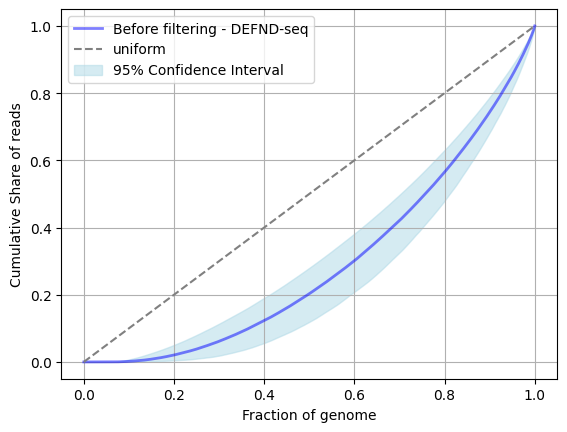

In [7]:
median_lorenz = np.median(lorenz_matac_2d, axis=0)
lower_bound = np.percentile(lorenz_matac_2d, 2.5, axis=0)
upper_bound = np.percentile(lorenz_matac_2d, 97.5, axis=0)

x_values = np.arange(len(median_lorenz)) / (len(median_lorenz) - 1)

plt.plot(
    x_values,
    median_lorenz,
    label="Before filtering - DEFND-seq",
    lw=2,
    color="blue",
    alpha=0.5,
)
plt.plot(x_values, x_values, label="uniform", ls="--", color="grey")
plt.fill_between(
    x_values,
    lower_bound,
    upper_bound,
    color="lightblue",
    alpha=0.5,
    label="95% Confidence Interval",
)

plt.xlabel("Fraction of genome")
plt.ylabel("Cumulative Share of reads")
plt.legend()
plt.grid(True)

Text(0, 0.5, 'Count')

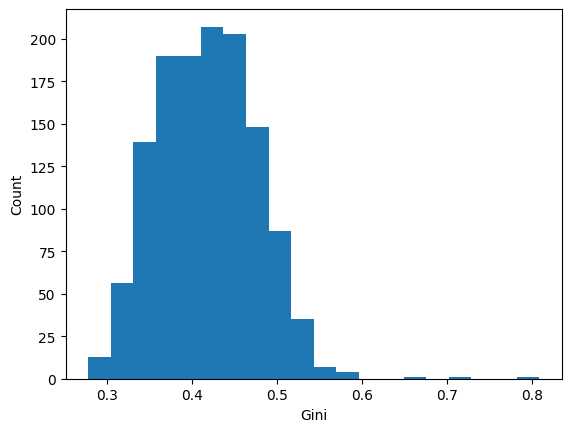

In [8]:
plt.hist(gini_matac, bins=20)
plt.xlabel("Gini")
plt.ylabel("Count")

In [9]:
atac = ad.AnnData(counts_df_orig)

In [10]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

In [11]:
atac.obs.rename(
    columns={
        "n_genes_by_counts": "n_features_per_cell",
    },
    inplace=True,
)

In [12]:
atac.obs["log_total_counts"] = np.log10(atac.obs["total_counts"])

In [13]:
ac.tl.locate_fragments(
    atac,
    "../../aurelie_data/revision_data/dna/2_LFS_DEFND_multiome_2/outs/atac_fragments.tsv.gz",
)

In [14]:
ac.tl.nucleosome_signal(atac)

Reading Fragments: 100%|██████████| 12820000/12820000 [00:48<00:00, 263460.64it/s]


(0.0, 2.0)

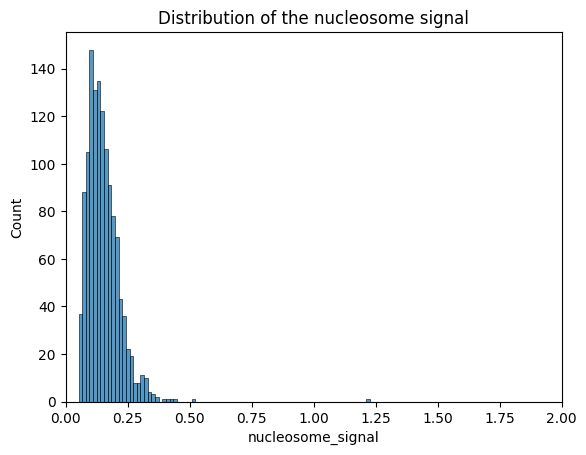

In [15]:
sns.histplot(atac.obs, x="nucleosome_signal")
plt.title("Distribution of the nucleosome signal")
plt.xlim(0, 2)

In [16]:
features = pd.read_csv(
    "rna_features.csv",
    index_col=0,
)
features = features.loc[~features.Start.isnull()]
features.Start = features.Start.astype(int)
features.End = features.End.astype(int)

In [17]:
tss = ac.tl.tss_enrichment(atac, n_tss=100000, random_state=666, features=features)

Fetching Regions...: 100%|██████████| 36588/36588 [02:49<00:00, 215.32it/s]


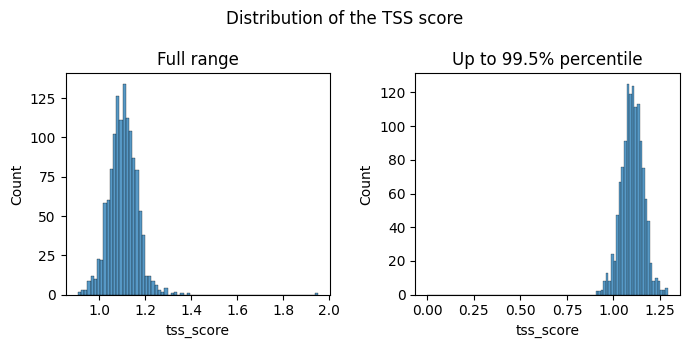

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))

p1 = sns.histplot(atac.obs, x="tss_score", ax=axs[0])
p1.set_title("Full range")

p2 = sns.histplot(
    atac.obs,
    x="tss_score",
    binrange=(0, atac.obs["tss_score"].quantile(0.995)),
    ax=axs[1],
)
p2.set_title("Up to 99.5% percentile")

plt.suptitle("Distribution of the TSS score")

plt.tight_layout()

In [19]:
region = "chr1:1-24895642"
hg_size = 3099706404

fragment_path = atac.uns["files"]["fragments"]
fragments = tools.fetch_regions_to_df(fragment_path=fragment_path, features=region)

fragments["length"] = fragments.End - fragments.Start
fragments.set_index(keys="Cell", inplace=True)
fragments = fragments.join(atac.obs, how="right")
f_length = fragments.length.median()
atac.obs["coverage"] = (atac.obs["total_counts"] * f_length) / hg_size

Fetching Regions...: 100%|██████████| 1/1 [01:02<00:00, 62.24s/it]


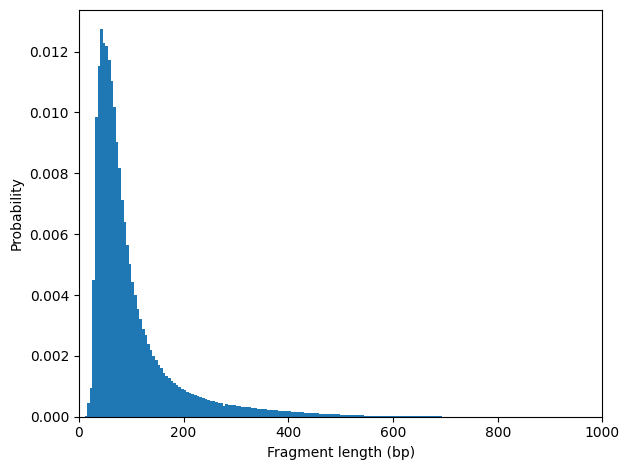

In [20]:
plt.hist(x=fragments["length"], bins=1000, density=True)
plt.xlim((0, 1000))
plt.xlabel("Fragment length (bp)")
plt.ylabel("Probability")
plt.tight_layout()

In [21]:
atac.obs["gini"] = gini_matac

In [22]:
atac.write("defnd_processed.h5ad")

In [23]:
atac = sc.read_h5ad("defnd_processed.h5ad")

### Read CNAs

In [24]:
all_cnv_files = glob.glob("../../DEFND-seq/HMMcopy_1MB/*per_bin_calls_long.bed")
len(all_cnv_files)

1282

In [25]:
cna = prepare_cnvs(all_cnv_files)

100%|██████████| 1282/1282 [02:04<00:00, 10.31it/s]


In [26]:
# The threshold of 0.9 worked well in our case, but it might not be ideal for your case
cna = cna.loc[atac[atac.obs["n_features_per_cell"] > 0.9 * len(atac.var)].obs_names]
# We subtract 1 from our data, since HMMcopy reports the copy number as values CN + 1
cna = cna - 1
# We will also replace all 0s with 1s, as we noticed that with HMMcopy
# we could not distinguish homozygous and heterozygous deletions
cna.replace(0, 1, inplace=True)
cna

bin,chr1:1-1000001,chr1:1000001-2000001,chr1:2000001-3000001,chr1:3000001-4000001,chr1:4000001-5000001,chr1:5000001-6000001,chr1:6000001-7000001,chr1:7000001-8000001,chr1:8000001-9000001,chr1:9000001-10000001,...,chrY:48000001-49000001,chrY:49000001-50000001,chrY:50000001-51000001,chrY:51000001-52000001,chrY:52000001-53000001,chrY:53000001-54000001,chrY:54000001-55000001,chrY:55000001-56000001,chrY:56000001-57000001,chrY:57000001-58000001
GTCATCACAAGCTTTG-1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
CCCTGGACATTCCTCG-1,4,4,4,4,4,4,4,4,4,4,...,2,2,2,2,2,2,2,2,2,2
AGCTGCTCAGGTTAAA-1,3,3,3,3,3,3,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
CGGTGAACATGAATAG-1,5,5,5,5,5,5,5,5,5,5,...,1,1,1,1,1,1,1,1,1,1
AATTAGCGTGAGACTC-1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGGATCCGTTTGCTGT-1,5,5,5,5,5,5,5,5,5,5,...,1,1,1,1,1,1,1,1,1,1
CGCTAACCAAATACCT-1,5,5,5,5,5,5,5,5,1,1,...,1,1,1,1,1,1,1,1,1,1
ATGTTTGAGCTGTAAC-1,5,5,5,5,5,5,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
TACAGGTTCCCTCAAC-1,5,5,5,5,5,5,5,5,5,5,...,1,1,1,1,1,1,1,1,1,1


In [27]:
rna_barcodes = []
with open("../../cell_calling/DEFND_barcodes_rna.tsv") as fin:
    for line in fin:
        rna_barcodes.append(line.rstrip())

In [28]:
cna = cna.loc[
    [bar for bar in rna_barcodes if bar in cna.index],
    [col for col in cna.columns if not col.startswith("chrY")],
].copy()

In [29]:
cna.to_csv("../data/CNVs_DEFND_filtered.csv.gz")

Lets read the dataframe with anndata

In [30]:
# Before creating anndata object, we will center the neutral state to 0, so
# that all values are between -1 and 1
cna = (cna - 2) / 3
adata = sc.AnnData(cna)

In [31]:
# Adding QC data from above to the new anndata object
adata.obs = adata.obs.join(atac.obs)

In [32]:
# Preparing genomic features
adata.var["chromosome"] = adata.var.index.str.split(":").str[0]
adata.var["start"] = (
    adata.var.index.str.split(":").str[1].str.split("-").str[0].astype(int)
)
adata.var["end"] = (
    adata.var.index.str.split(":").str[1].str.split("-").str[1].astype(int)
)

In [33]:
adata.var

,chromosome,start,end
bin,,,
chr1:1-1000001,chr1,1,1000001
chr1:1000001-2000001,chr1,1000001,2000001
chr1:2000001-3000001,chr1,2000001,3000001
chr1:3000001-4000001,chr1,3000001,4000001
chr1:4000001-5000001,chr1,4000001,5000001
...,...,...,...
chrX:152000001-153000001,chrX,152000001,153000001
chrX:153000001-154000001,chrX,153000001,154000001
chrX:154000001-155000001,chrX,154000001,155000001


In [34]:
adata.var.columns = ["chromosome", "start", "end"]
adata.obsm["X_cnv"] = adata.X
adata.var["pos"] = np.arange(adata.var.shape[0])
chrom_dict = {}
chrom_dict["chr_pos"] = {}
for tup in adata.var.itertuples():
    if tup.chromosome not in chrom_dict["chr_pos"]:
        chrom_dict["chr_pos"][tup.chromosome] = tup.pos
    if chrom_dict["chr_pos"][tup.chromosome] > tup.pos:
        chrom_dict["chr_pos"][tup.chromosome] = tup.pos
adata.uns["cnv"] = chrom_dict

... storing 'chromosome' as categorical


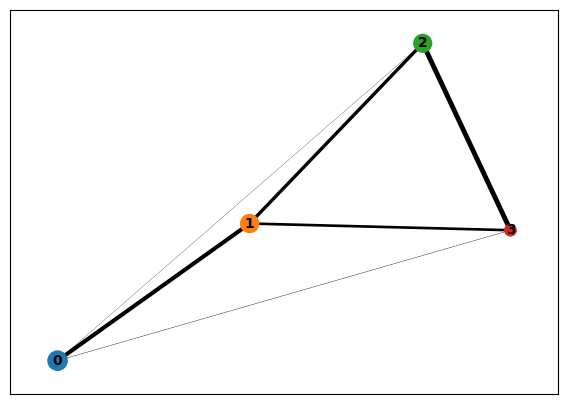

In [35]:
# Perform basic clustering
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.leiden(adata, key_added="cnv_leiden", resolution=0.5)
sc.tl.paga(adata, groups="cnv_leiden")
sc.pl.paga(adata, plot=True)
sc.tl.umap(adata, init_pos="paga")

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


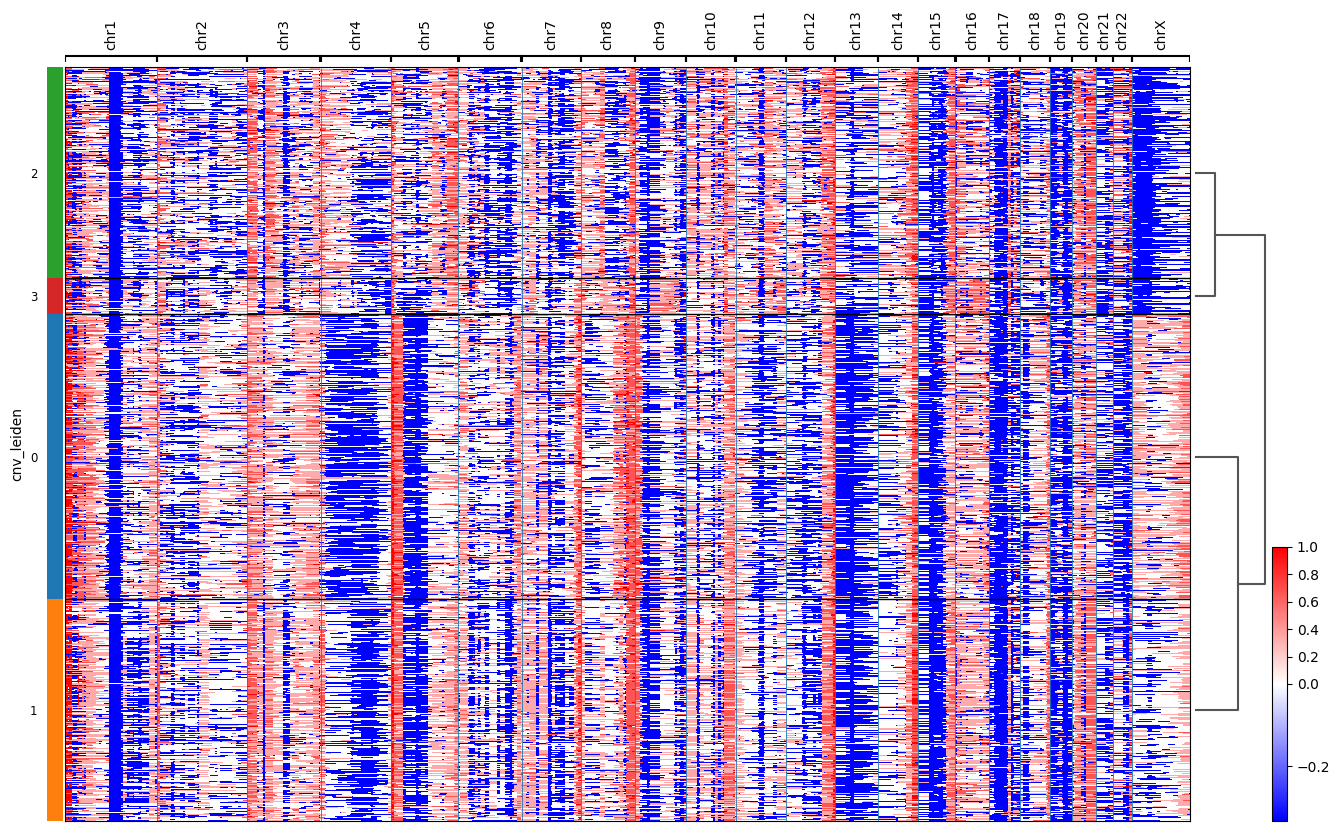

In [36]:
# Plot the heatmap with CNVs
cnv.pl.chromosome_heatmap(
    adata, groupby="cnv_leiden", dendrogram=True, figsize=(16, 10)
)

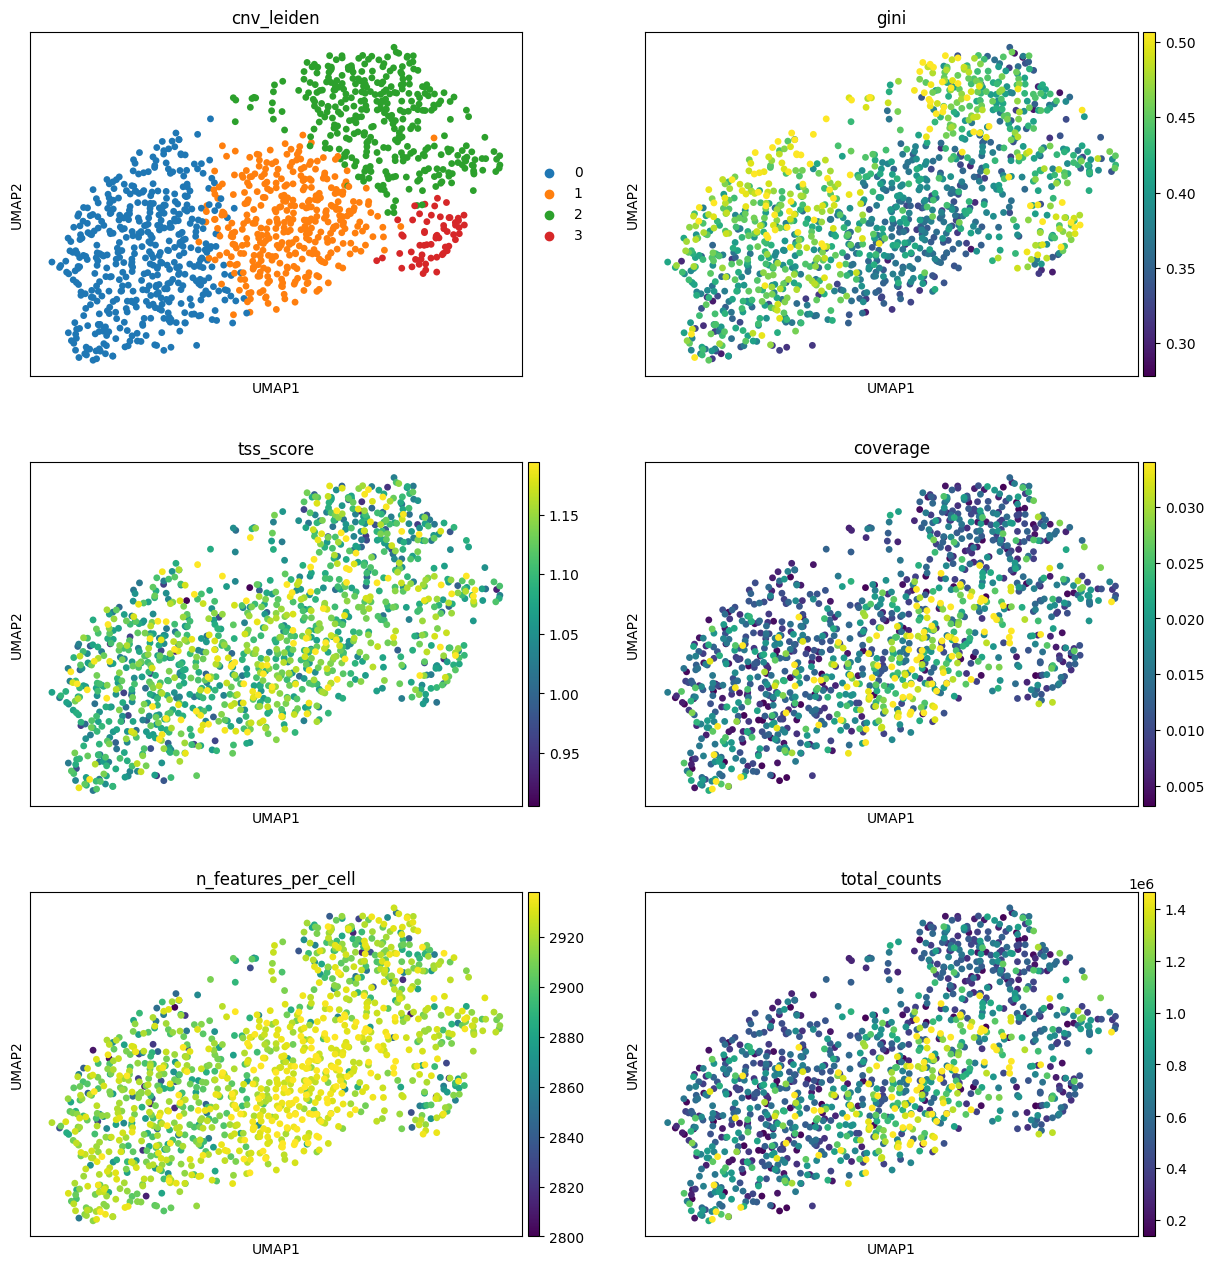

In [37]:
sc.pl.umap(
    adata,
    color=[
        "cnv_leiden",
        "gini",
        "tss_score",
        "coverage",
        "n_features_per_cell",
        "total_counts",
    ],
    ncols=2,
    vmax="p95",
)